In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm.auto import tqdm
from torch.utils.data import Subset
import math
from datasets import load_dataset
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

The Models

In [9]:
from ResAttUNet import ResidualAttentionUNet
from ResUNet import ResidualUNet32
from ConvUNet import ConvUNet32

In [10]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [11]:
import wandb

In [12]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
config = dict(
    epochs=40,
    learning_rate=0.0001,
    opt="AdamW",
    n_steps = 1000,
    architecture="residualunet"
)

In [14]:
def model_pipeline(hyperparameters):

    with wandb.init(project="diffusion-pytorch", config=hyperparameters):
        config = wandb.config
        model, dataset, optimizer, alpha, beta, alpha_bar = make(config)
        #print(model)
        trainer(dataset, model, optimizer, config, alpha, beta, alpha_bar)
    return model

In [15]:
def make(config):
    # Making the data
    dataset = get_data()

    if config.architecture == "residualunet":
        model = ResidualUNet32().cuda()
    elif config.architecture == "residualattentionunet":
        model = ResidualAttentionUNet().cuda()
    elif config.architecture == "convunet":
        model = ConvUNet32().cuda()


    if config.opt == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    elif config.opt == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    #elif config.opt == "sgd":
        #optimizer = torch.optim.SGD(model.parameters(),lr=config.learning_rate, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    #opt = build_optimizer(model, config.opt, config.learning_rate)
    
    beta = torch.linspace(0.0001, 0.04, config.n_steps).cuda()
    alpha = 1. - beta
    alpha_bar = torch.cumprod(alpha, dim=0)

    return model, dataset, optimizer, alpha, beta, alpha_bar

In [16]:
def get_data():
    dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
    return dataset

In [17]:
def q_xt_x0(x0, t,alpha_bar):    
    eps=torch.randn(x0.shape).cuda()
    alpha_bar_t = alpha_bar[t-1]
    xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1-alpha_bar_t) * eps
    return xt , eps

In [18]:
def calc_loss(model: torch.nn.Module, x: torch.Tensor, n_steps, alpha_bar) -> torch.Tensor:
    
    t=torch.randint(1,n_steps,(len(x),1,1,1)).cuda()
    x_t,eps = q_xt_x0(x,t,alpha_bar)
    t=t.reshape(len(x),)
    eps_t = model(x_t,t)
    loss = F.mse_loss(eps_t, eps)
    return loss

In [19]:
def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

In [20]:
def p_xt(xt, noise, t, alpha, beta, alpha_bar):
    
    alpha_t = alpha[t-1]
    alpha_bar_t = alpha_bar[t-1]
    if t>1:
      z = torch.randn(xt.shape).cuda()
    else:
      z = torch.zeros(xt.shape).cuda()
    sigma_t = torch.sqrt(beta[t-1])
    x_tm1 = (  xt - ( noise*(1-alpha_t)/torch.sqrt(1-alpha_bar_t) )  ) / (torch.sqrt(alpha_t))  + sigma_t*z
    return x_tm1

In [21]:
def trainer(dataset, model, optimizer, config, alpha, beta, alpha_bar):
    
    dloader=torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
    t0 = time.time()
    losses = []
    wandb.watch(model, calc_loss, log="all", log_freq=10)
    for i_epoch in range (config.epochs):
        total_loss = 0
        for data in dloader:
            optimizer.zero_grad()
            loss = calc_loss(model,(2*data[0]-1).cuda(),config.n_steps, alpha_bar)
            loss.backward()
            optimizer.step()
        print(f"{i_epoch+1} ({time.time() - t0}s): {loss.item()}")
        losses.append(loss.item())
        wandb.log({"loss": loss.item()}, step=i_epoch)
    plt.plot(losses)
    
    x = torch.randn(18, 3, 32, 32).cuda()
    ims = []
    
    for i in range(config.n_steps):
        t = torch.tensor(config.n_steps-i-1, dtype=torch.long).cuda()
        with torch.no_grad():
            pred_noise = model(x.float(), t.unsqueeze(0))
            x = p_xt(x, pred_noise, t.unsqueeze(0), alpha, beta, alpha_bar)
    
    for i in range(18):
        ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))
        
        
    num_images = len(ims)
    cols = 6 
    rows = 3
    plt.figure(figsize=(cols, rows))
    for i, im in enumerate(ims):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(im)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig('/kaggle/working/output_img.png')
    wandb.log({"Generated Images": [wandb.Image(im) for im in ims]})

# Residual UNet

In [22]:
config = dict(
    epochs=40,
    learning_rate=0.0001,
    opt="AdamW",
    n_steps = 1000,
    architecture="residualunet"
)

wandb: Currently logged in as: shivank2023-nn. Use `wandb login --relogin` to force relogin


100%|██████████| 170498071/170498071 [00:05<00:00, 29828713.70it/s]


Extracting data/cifar-10-python.tar.gz to data/
1 (108.66599202156067s): 0.0690266489982605
2 (214.97775650024414s): 0.03235061839222908
3 (320.9255018234253s): 0.03545796126127243
4 (426.72707772254944s): 0.03473953902721405
5 (532.5561401844025s): 0.015483550727367401
6 (638.2803726196289s): 0.0353873185813427
7 (744.320365190506s): 0.03352662920951843
8 (850.3274533748627s): 0.032888468354940414
9 (957.6976635456085s): 0.021445823833346367
10 (1065.4027826786041s): 0.03741835802793503
11 (1172.0315136909485s): 0.021778082475066185
12 (1278.3566398620605s): 0.022504569962620735
13 (1384.4938583374023s): 0.03577826917171478
14 (1491.039766550064s): 0.025320660322904587
15 (1597.5403289794922s): 0.02386603318154812
16 (1705.0048608779907s): 0.02054164931178093
17 (1811.706557750702s): 0.022139128297567368
18 (1917.7728888988495s): 0.027462366968393326
19 (2024.2269673347473s): 0.01397253293544054
20 (2131.974745988846s): 0.02173469215631485
21 (2238.5172407627106s): 0.02082793787121772

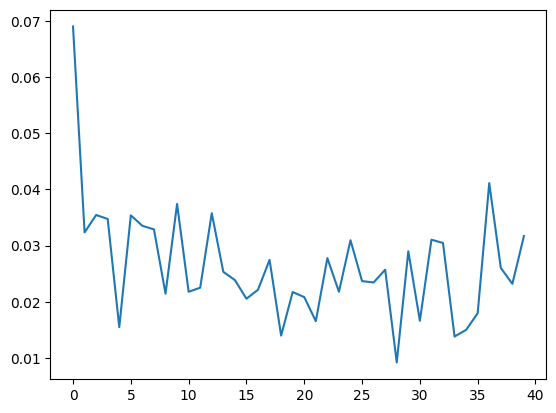

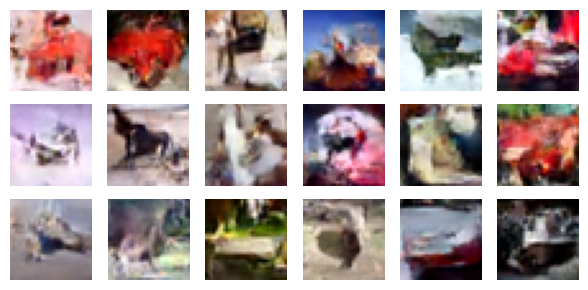

loss,█▄▄▄▂▄▄▄▂▄▂▃▄▃▃▂▃▃▂▂▂▂▃▂▄▃▃▃▁▃▂▄▃▂▂▂▅▃▃▄
loss,0.0317


<Figure size 640x480 with 0 Axes>

In [23]:
model = model_pipeline(config)

# Residual Attention UNet

In [24]:
config2 = dict(
    epochs=40,
    learning_rate=0.0001,
    opt="AdamW",
    n_steps = 1000,
    architecture="residualattentionunet"
)

Files already downloaded and verified
1 (121.84357333183289s): 0.0779377669095993
2 (243.03648853302002s): 0.0677577555179596
3 (363.9568974971771s): 0.04833606258034706
4 (484.9164490699768s): 0.025465773418545723
5 (605.0044367313385s): 0.03201612830162048
6 (725.0752739906311s): 0.03458603471517563
7 (845.1463646888733s): 0.02894607186317444
8 (965.0788786411285s): 0.028789009898900986
9 (1085.268100976944s): 0.025259502232074738
10 (1207.1351747512817s): 0.02249227650463581
11 (1326.797161579132s): 0.016851535066962242
12 (1446.6050407886505s): 0.01460437010973692
13 (1566.3716235160828s): 0.02927379310131073
14 (1686.3803849220276s): 0.022464828565716743
15 (1806.3316404819489s): 0.03111143782734871
16 (1926.559023141861s): 0.03207575902342796
17 (2046.55060505867s): 0.022668518126010895
18 (2166.3240191936493s): 0.0243407990783453
19 (2286.5676012039185s): 0.022812077775597572
20 (2408.3228256702423s): 0.029312992468476295
21 (2528.929428577423s): 0.028882281854748726
22 (2649.24

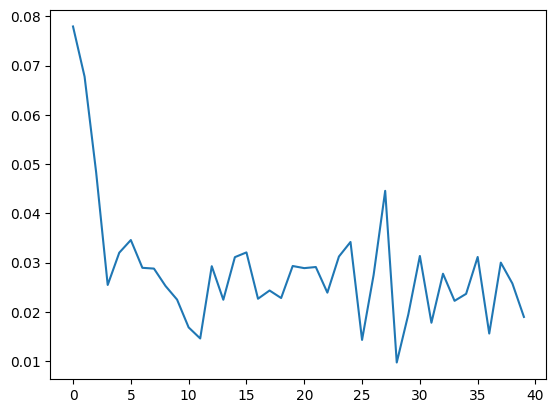

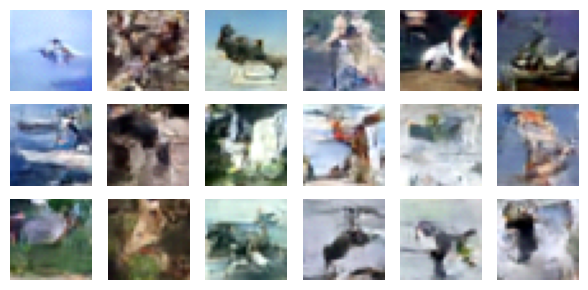

loss,█▇▅▃▃▄▃▃▃▂▂▂▃▂▃▃▂▂▂▃▃▃▂▃▄▁▃▅▁▂▃▂▃▂▂▃▂▃▃▂
loss,0.01897


<Figure size 640x480 with 0 Axes>

In [25]:
model = model_pipeline(config2)

# Convolutional UNet

In [50]:
config3 = dict(
    epochs=40,
    learning_rate=0.0001,
    opt="AdamW",
    n_steps = 1000,
    architecture="convunet"
)

Files already downloaded and verified
1 (95.66712284088135s): 0.4519612789154053
2 (189.55258297920227s): 0.3434724807739258
3 (283.3615074157715s): 0.302754670381546
4 (377.3946998119354s): 0.26211848855018616
5 (471.2860481739044s): 0.2588111460208893
6 (564.9822528362274s): 0.22338399291038513
7 (658.4394180774689s): 0.20618613064289093
8 (752.4467985630035s): 0.17618489265441895
9 (846.4531440734863s): 0.1753147542476654
10 (940.9746088981628s): 0.14891205728054047
11 (1034.2528660297394s): 0.13473497331142426
12 (1127.9848158359528s): 0.15317197144031525
13 (1221.9501585960388s): 0.13259488344192505
14 (1315.2712576389313s): 0.15697044134140015
15 (1408.430611371994s): 0.14548169076442719
16 (1502.0620033740997s): 0.13751691579818726
17 (1595.326933145523s): 0.11398080736398697
18 (1688.6292226314545s): 0.12241230905056
19 (1782.1688981056213s): 0.12545402348041534
20 (1876.0580673217773s): 0.11667852848768234
21 (1969.4816064834595s): 0.11643511801958084
22 (2062.6025898456573s):

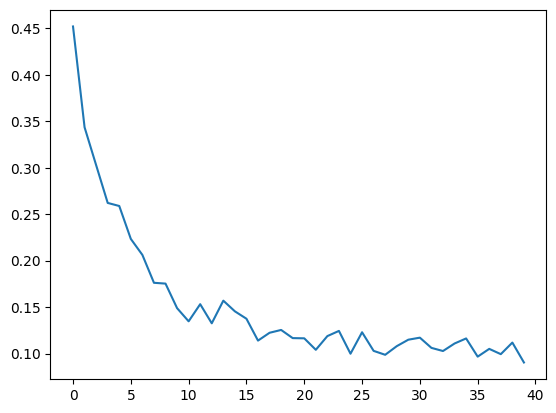

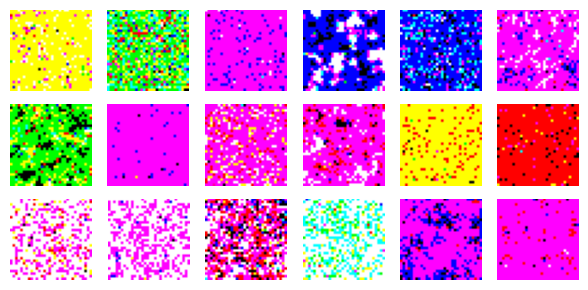

loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁
loss,0.09045


<Figure size 640x480 with 0 Axes>

In [51]:
model = model_pipeline(config3)